In [195]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math,os

import pickle
# from tqdm import tqdm,trange, tqdm_notebook
from tqdm import tqdm_notebook as tqdm
import numpy.linalg as npl
import itertools
import scipy.special,time, scipy.stats
from collections import Counter
from scipy.special import comb as choose
import sklearn.cluster
# import sklearn.metrics.pairwise_distances

In [130]:
np.random.seed(7)
d=2
clusterSizes = 50
numClusters = 4
n=clusterSizes*numClusters
dataSet = np.random.normal(size=(n,d),scale=.5)
clusterCenters = np.random.normal(size=(numClusters,d),scale=5)
for i in range(numClusters):
    dataSet[i*clusterSizes:(i+1)*clusterSizes] += clusterCenters[i]


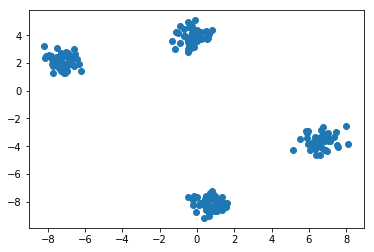

In [131]:
plt.figure()
plt.scatter(dataSet[:,0],dataSet[:,1])

In [78]:
def compGap(data,k):
    
    if k==1:
        dists = sklearn.metrics.pairwise_distances(data,metric='sqeuclidean')
        return dists.sum()/4/data.shape[0]
    
    centroid,labels,inertia = sklearn.cluster.k_means(data,k)
    D = np.zeros(k)
    counts = np.zeros(k)
    for (i,li) in enumerate(labels):
        counts[li]+=1
        for (j,lj) in enumerate(labels):
            if li != lj or j <= i:
                continue
            D[li] += np.linalg.norm(data[i]-data[j])**2
    
    return np.sum(D/counts/2)
    

In [133]:
kArr = range(1,10)

### dataset
lows = np.min(dataSet,axis=0)
highs = np.max(dataSet,axis=0)


WkArr = np.zeros(len(kArr))
WkbArr = np.zeros(len(kArr))
WkbStdArr = np.zeros(len(kArr))
numSamplesArr = np.zeros(len(kArr))
for (loc,k) in tqdm(enumerate(kArr),total = len(kArr)):
    Wk = compGap(dataSet,k)
    WkArr[loc] = Wk
    
    WkbTrials = []
    for b in range(10):
        dataFake = np.zeros((n,d))
        for i in range(d):
            dataFake[:,i] = np.random.uniform(lows[i],highs[i],size=n)
        
        WkbTrials.append(compGap(dataFake,k))
    WkbArr[loc] = np.mean(WkbTrials)
    WkbStdArr[loc] = np.std(WkbTrials)

In [134]:
gapArr = WkbArr-WkArr

In [137]:
gapArr

array([-820.139419  ,  813.1898326 ,  749.72059139,  882.14135892,
        716.87785842,  581.69616473,  491.19136286,  415.94591229,
        360.87428908])

In [136]:
for i in range(len(gapArr)-1):
    print(gapArr[i] - gapArr[i+1],kArr[i])

-1633.3292516032234 1
63.46924121303209 2
-132.42076752701882 3
165.2635005017204 4
135.18169368456472 5
90.50480187082752 6
75.24545057193455 7
55.07162321119148 8


In [184]:

def gapStat(dataSet,kMax=20,maxPulls=20,const=5):

#     kMax = 20
    
#     const = 5

    ### dataset
    lows = np.min(dataSet,axis=0)
    highs = np.max(dataSet,axis=0)

    B = maxPulls
    dataFakes = np.zeros((B,n,d))
    for t in range(B):
        dataFake = np.zeros((n,d))
        for i in range(d):
            dataFake[:,i] = np.random.uniform(lows[i],highs[i],size=n)
        dataFakes[t] = dataFake
    

    WkArr = np.zeros(kMax)
    WkbArr = np.zeros(kMax)
    numSamplesArr = np.zeros(kMax)


    prevArr = []
    currArr = []

    WkArr[1] = compGap(dataSet,1)
    
    itersUsed = 0
    
    k=2
    while k<kMax:
        currArr = []
        WkArr[k] = compGap(dataSet,k)

        t=0
        while t<maxPulls//2:
            itersUsed+=2
#             print(k,t)

#             dataFake = np.zeros((n,d))
#             for i in range(d):
#                 dataFake[:,i] = np.random.uniform(lows[i],highs[i],size=n)

            prevArr.append(compGap(dataFakes[t],k-1))
            currArr.append(compGap(dataFakes[t+maxPulls//2],k))

            if t<1:
                t+=1
                continue
            ##### need to do actual confidence intervals
#             if np.mean(prevArr) - WkArr[k-1] >= np.mean(currArr) - WkArr[k] - np.sqrt(1+1.0/len(currArr))*np.std(currArr):
#                 return k-1,itersUsed

#             if np.mean(prevArr) - WkArr[k-1] <= np.mean(currArr) - WkArr[k] - 5*np.sqrt(1+1.0/len(currArr))*np.std(currArr):
#                 break
#             print(k,t)
#             print(np.mean(prevArr) - WkArr[k-1], const*np.std(prevArr)/np.sqrt(len(prevArr)))
#             print(np.mean(currArr) - WkArr[k], const*np.std(currArr)/np.sqrt(len(currArr)))
            if np.mean(prevArr) - WkArr[k-1] - const*np.std(prevArr)/np.sqrt(len(prevArr)) >= np.mean(currArr) - WkArr[k] +(const/np.sqrt(len(currArr)) -1)*np.std(currArr):
                return k-1,itersUsed

            if np.mean(prevArr) - WkArr[k-1] + const*np.std(prevArr)/np.sqrt(len(prevArr)) <= np.mean(currArr) - WkArr[k] -(const/np.sqrt(len(currArr)) +1)*np.std(currArr):
                break


            t+=1
        prevArr=currArr

        k+=1
        
    return kMax,itersUsed

In [166]:

def gapStatBrute(dataSet,B=20):

    kMax = 20
    

    ### dataset
    lows = np.min(dataSet,axis=0)
    highs = np.max(dataSet,axis=0)


    WkArr = np.zeros(kMax)
    WkbArr = np.zeros((kMax,B))
    

    dataFakes = np.zeros((B,n,d))
    for t in range(B):
        dataFake = np.zeros((n,d))
        for i in range(d):
            dataFake[:,i] = np.random.uniform(lows[i],highs[i],size=n)
        dataFakes[t] = dataFake
    
    
    for k in range(1,kMax):

        WkArr[k] = compGap(dataSet,k)


        for t in range(B):

            dataFake = dataFakes[t]
            
            WkbArr[k,t] = compGap(dataFake,k)



        if k>1 and np.mean(WkbArr[k-1]) - WkArr[k-1]>= np.mean(WkbArr[k]) - WkArr[k] -np.std(WkbArr[k]):
            return k-1,k*B

        
    return kMax,kMax*B


In [140]:
gapStat(dataSet)

2 2
-862.8207543957255 9.091079125576085
854.7637382970884 6.206502418656465
3 2
800.1109543361881 3.926124414915465
663.0279778716058 2.5542535228664454


(2, 12)

In [191]:
### testing
numTrials = 10
d=3
clusterSizes = 50
numClusters = 4
n=clusterSizes*numClusters

maxPulls = 20
const = 5

answers = np.zeros(numTrials)
samplesUsed = np.zeros(numTrials)

bruteAnswer = np.zeros(numTrials)
bruteSamplesUsed = np.zeros(numTrials)
for t in tqdm(range(numTrials)):
    np.random.seed(t)
    while True:
        clusterCenters = np.random.normal(size=(numClusters,d),scale=5)
        valid = True
        for i in range(numClusters):
            for j in range(i+1,numClusters):
                if np.linalg.norm(clusterCenters[i]-clusterCenters[j]) <=1:
                    valid = False
        if valid:
            break
        
#     print(clusterCenters)
    dataSet = np.random.normal(size=(n,d),scale=.1)

    for i in range(numClusters):
        dataSet[i*clusterSizes:(i+1)*clusterSizes] += clusterCenters[i]

    a,s = gapStat(dataSet, kMax=20,maxPulls=maxPulls, const=5)
    answers[t]=a
    samplesUsed[t]=s

    
#     a,s = gapStatBrute(dataSet, B=maxPulls)
#     bruteAnswer[t]=a
#     bruteSamplesUsed[t]=s
    
    
for t in range(numTrials):
    print(t,answers[t],bruteAnswer[t],samplesUsed[t],bruteSamplesUsed[t])
# print(answers)
# print(bruteAnswer)
# print(samplesUsed)

0 4.0 0.0 34.0 0.0
1 2.0 0.0 8.0 0.0
2 4.0 0.0 34.0 0.0
3 4.0 0.0 16.0 0.0
4 3.0 0.0 14.0 0.0
5 4.0 0.0 16.0 0.0
6 4.0 0.0 16.0 0.0
7 3.0 0.0 12.0 0.0
8 4.0 0.0 22.0 0.0
9 4.0 0.0 32.0 0.0


In [192]:
np.mean(answers==4),np.mean(samplesUsed)

(0.7, 20.4)

In [190]:
np.mean(answers==4),np.mean(samplesUsed)

(0.5, 15.0)

In [177]:
np.sum(samplesUsed)

216.0

In [172]:
answers, samplesUsed

(array([ 4.,  5.,  4.,  4.,  4., 13.,  4., 20.,  4.,  6.]),
 array([ 16.,  36.,  16.,  18.,  28., 198.,  16., 312.,  28.,  72.]))

In [471]:
np.random.seed(0)
    
numClusters=4
clusterSizes = np.random.choice([25,50],size=numClusters)
n = np.sum(clusterSizes)

d=2



clusterCenters = np.array([[1,0],[0,1],[-1,0],[0,-1]])

dataSet = np.random.normal(size=(n,d),scale=.2)
lens = np.cumsum(clusterSizes)
dataSet[:lens[0]] +=clusterCenters[0]
for i in range(numClusters-1):
    dataSet[lens[i]:lens[i+1]] += clusterCenters[i+1]

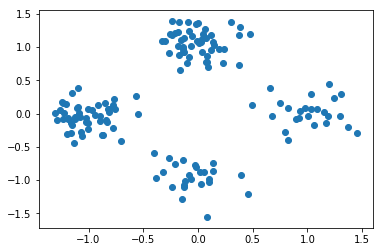

In [472]:
plt.figure()
plt.scatter(dataSet[:,0],dataSet[:,1])

# Plotting

In [482]:
constArr = [1]
numTrials = 50
maxPulls = 200
kMax = 10

setup =6
answer=4

adaDataOut = np.zeros((len(constArr),numTrials))
adaDataPullsUsed = np.zeros((len(constArr),numTrials))
adaWkArr = np.zeros((len(constArr),numTrials,kMax))
adaWkbArr = np.zeros((len(constArr),numTrials,kMax,maxPulls))

n=200
d=3
adaDataSets = np.zeros((len(constArr),numTrials,n,d))

for (i,const) in enumerate(constArr):
    for j in range(numTrials):
        myData = pickle.load( open( "pkls_gap/ada_i{}_c{}_exp{}.pkl".format(setup,const,j), "rb" ) )
        adaDataOut[i,j] = myData["k"]
        adaDataPullsUsed[i,j] = myData["itersUsed"]
#         adaWkArr[i,j] = myData["WkArr"]
#         adaWkbArr[i,j] = myData["WkbArr"]
#         adaDataSets[i,j]=myData["dataSet"]

print((adaDataOut==answer).mean(axis=1))
print(adaDataPullsUsed.mean(axis=1))

[0.88]
[13.92]


In [459]:
adaDataOut[0]

array([10., 10., 10., 10.,  9., 10., 10., 10., 10., 10., 10., 10., 10.,
       10.,  9., 10.,  9.,  9., 10.,  8., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10.,  8., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10.,  9., 10., 10., 10.])

In [483]:
maxPulls = 3
kMax = 10
numTrials = 50
bruteOut = np.zeros(numTrials)
brutePullsUsed = np.zeros(numTrials)
bruteWkArr = np.zeros((numTrials,kMax))
bruteWkbArr = np.zeros((numTrials,kMax,maxPulls))
bruteDataSets = np.zeros((numTrials,n,d))
for i in range(numTrials):
    myData = pickle.load( open( "pkls_gap/naive_i{}_p{}_exp{}.pkl".format(setup,maxPulls,i), "rb" ) )
    bruteOut[i] = myData["k"]
    brutePullsUsed[i] = myData["itersUsed"]
#     bruteWkArr[i] = myData["WkArr"]
#     bruteWkbArr[i] = myData["WkbArr"]
#     bruteDataSets[i] = myData["dataSet"]

print((bruteOut==answer).mean())
print(brutePullsUsed.mean())

0.88
14.28


In [476]:
bruteOut

array([1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.])

In [449]:
d=10
numClusters=10
clusterSizes = np.random.choice([25,50],size=numClusters)
n = np.sum(clusterSizes)



while True:
    clusterCenters = np.random.normal(size=(numClusters,d))
    clusterCenters= clusterCenters / np.linalg.norm(clusterCenters,axis=1,keepdims=True)*5
    valid = True
    for i in range(numClusters):
        for j in range(i+1,numClusters):
            if np.linalg.norm(clusterCenters[i]-clusterCenters[j]) <=5:
                valid = False
    if valid:
        break

dataSet = np.random.normal(size=(n,d),scale=.1)
lens = np.cumsum(clusterSizes)
dataSet[:lens[0]] +=clusterCenters[0]
for i in range(numClusters-1):
    dataSet[lens[i]:lens[i+1]] += clusterCenters[i+1]



In [447]:
centroid,labels,inertia = sklearn.cluster.k_means(dataSet,4)

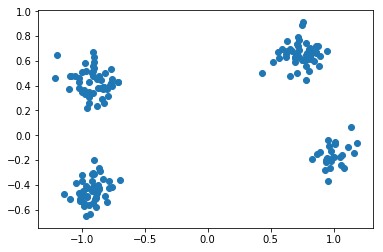

In [448]:
plt.scatter(dataSet[:,0],dataSet[:,1])
# plt.scatter(clusterCenters[:,0],clusterCenters[:,1],c='red')
# plt.scatter(centroid[:,0],centroid[:,1],c='yellow')

In [259]:
bruteWkArr[1]

array([   0.        , 8845.33531343,  579.24602569,  237.29374507,
          0.        ,    0.        ])

In [258]:
adaWkArr[0,1]

array([   0.        , 8845.33531343,  579.24602569,  237.29374507,
          0.        ,    0.        ])

In [266]:
brutePullsUsed

array([100.,  60.,  80., 100.,  80., 100., 100.,  80., 100.,  80., 100.,
       100., 100., 100.,  80., 100.,  80., 100., 100.,  80., 100.,  60.,
       100.,  80., 100., 100., 100., 100., 100., 100.,  80., 100.,  80.,
       100.,  60.,  80., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100.])

In [284]:
dataSet = np.random.normal(size=(100,2))
dataSet[25:50] += [0,5]
dataSet[50:] += [5,-3]

In [304]:
np.cumsum([1,5,15,20])

array([ 1,  6, 21, 41])

Text(0, 0.5, 'Percent accuracy')

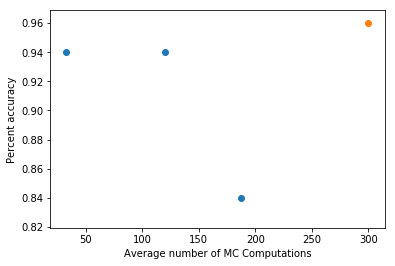

In [326]:
plt.figure()
plt.scatter(adaDataPullsUsed.mean(axis=1),(adaDataOut==answer).mean(axis=1))
plt.scatter(brutePullsUsed.mean(),(bruteOut==answer).mean())
plt.xlabel("Average number of MC Computations")
plt.ylabel("Percent accuracy")

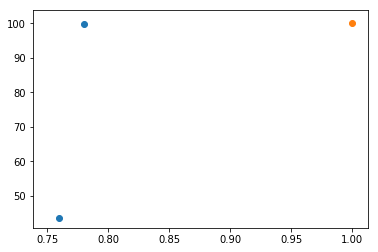

In [220]:
plt.figure()
plt.scatter((adaDataOut==4).mean(axis=1),adaDataPullsUsed.mean(axis=1))
plt.scatter((bruteOut==4).mean(),brutePullsUsed.mean())

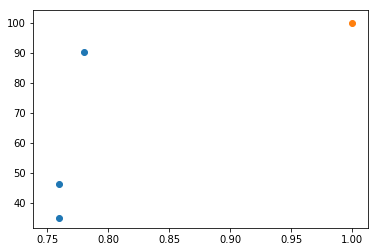

In [206]:
plt.figure()
plt.scatter((adaDataOut==4).mean(axis=1),adaDataPullsUsed.mean(axis=1))
plt.scatter((bruteOut==4).mean(),brutePullsUsed.mean())

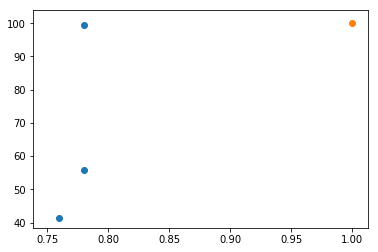

In [212]:
plt.figure()
plt.scatter((adaDataOut==4).mean(axis=1),adaDataPullsUsed.mean(axis=1))
plt.scatter((bruteOut==4).mean(),brutePullsUsed.mean())

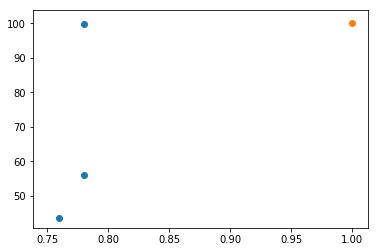

In [216]:
plt.figure()
plt.scatter((adaDataOut==4).mean(axis=1),adaDataPullsUsed.mean(axis=1))
plt.scatter((bruteOut==4).mean(),brutePullsUsed.mean())

In [213]:
adaDataOut

array([[4., 2., 3., 4., 3., 4., 4., 3., 4., 3., 4., 4., 4., 4., 3., 4.,
        3., 4., 4., 3., 4., 2., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4.,
        3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4.],
       [4., 2., 4., 4., 3., 4., 4., 3., 4., 3., 4., 4., 4., 4., 3., 4.,
        3., 4., 4., 3., 4., 2., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4.,
        3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4.],
       [4., 2., 4., 4., 3., 4., 4., 3., 4., 3., 4., 4., 4., 4., 3., 4.,
        3., 4., 4., 3., 4., 2., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4.,
        3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4.]])

In [210]:
adaDataPullsUsed[0,2]

64.0